<a href="https://colab.research.google.com/github/Nishorgo26/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Fashion-MNIST and CIFAR-10 datasets
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = keras.datasets.fashion_mnist.load_data()
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# Normalize pixel values to the range 0-1
X_train_fashion = X_train_fashion.astype("float32") / 255.0
X_test_fashion  = X_test_fashion.astype("float32")  / 255.0
X_train_cifar   = X_train_cifar.astype("float32")   / 255.0
X_test_cifar    = X_test_cifar.astype("float32")    / 255.0

# Resize Fashion-MNIST images from 28x28 to 32x32 and add 3 color channels
X_train_fashion_resized = tf.image.resize(X_train_fashion[..., np.newaxis], [32, 32]).numpy()
X_test_fashion_resized  = tf.image.resize(X_test_fashion[..., np.newaxis], [32, 32]).numpy()
# Duplicate the single grayscale channel into 3 channels (RGB)
X_train_fashion_resized = np.repeat(X_train_fashion_resized, 3, axis=-1)
X_test_fashion_resized  = np.repeat(X_test_fashion_resized, 3, axis=-1)

# CIFAR-10 images are already 32x32 and 3-channel.
X_train_cifar_resized = X_train_cifar  # shape (50000, 32, 32, 3)
X_test_cifar_resized  = X_test_cifar   # shape (10000, 32, 32, 3)

# Print dataset shapes to confirm
print("Fashion-MNIST train shape:", X_train_fashion_resized.shape, " labels:", y_train_fashion.shape)
print("Fashion-MNIST test  shape:", X_test_fashion_resized.shape,  " labels:", y_test_fashion.shape)
print("CIFAR-10 train shape:", X_train_cifar_resized.shape, " labels:", y_train_cifar.shape)
print("CIFAR-10 test  shape:", X_test_cifar_resized.shape,  " labels:", y_test_cifar.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Fashion-MNIST train shape: (60000, 32, 32, 3)  labels: (60000,)
Fashion-MNIST test  shape: (10000, 32, 32, 3)  labels: (10000,)
CIFAR-10 train shape: (50000, 32, 32, 3)  labels: (50000, 1)
CIFAR-10 test  shape: (10000, 32, 32, 3)  labels: (10000, 1)


In [2]:
# Function to shuffle and split data into training and validation sets
def split_train_val(X, y, val_fraction=0.2):
    # Shuffle the indices
    indices = np.arange(len(X))
    np.random.seed(42)  # for reproducibility
    np.random.shuffle(indices)
    # Reorder X and y accordingly
    X = X[indices]
    y = y[indices]
    # Compute split index
    val_size = int(len(X) * val_fraction)
    # Split into validation and remaining training data
    X_val = X[:val_size]
    y_val = y[:val_size]
    X_train_new = X[val_size:]
    y_train_new = y[val_size:]
    return X_train_new, y_train_new, X_val, y_val

# Prepare Fashion-MNIST splits (20% val)
X_train_fashion_final, y_train_fashion_final, X_val_fashion, y_val_fashion = split_train_val(
    X_train_fashion_resized, y_train_fashion, val_fraction=0.2
)

# Prepare CIFAR-10 splits (10% val)
y_train_cifar = y_train_cifar.flatten()  # flatten labels from shape (N,1) to (N,)
y_test_cifar  = y_test_cifar.flatten()
X_train_cifar_final, y_train_cifar_final, X_val_cifar, y_val_cifar = split_train_val(
    X_train_cifar_resized, y_train_cifar, val_fraction=0.1
)

# Print sizes of each split
print("Fashion-MNIST: Train set size:", X_train_fashion_final.shape[0],
      "| Val set size:", X_val_fashion.shape[0],
      "| Test size:", X_test_fashion_resized.shape[0])
print("CIFAR-10: Train set size:", X_train_cifar_final.shape[0],
      "| Val set size:", X_val_cifar.shape[0],
      "| Test size:", X_test_cifar_resized.shape[0])


Fashion-MNIST: Train set size: 48000 | Val set size: 12000 | Test size: 10000
CIFAR-10: Train set size: 45000 | Val set size: 5000 | Test size: 10000


In [3]:
from tensorflow.keras.applications import MobileNetV2

# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),    # random horizontal flip
    layers.RandomRotation(0.1),         # random rotation (±10%)
    layers.RandomZoom(0.1)             # random zoom
    # Note: We avoid color jitter for simplicity.
])

# Define MobileNetV2 base model (no pre-trained weights, 10 output classes)
base_model = MobileNetV2(weights=None, include_top=True, input_shape=(32, 32, 3), classes=10)

# Define preprocessing layer to scale inputs to [-1, 1] for MobileNetV2
preprocessing_layer = layers.Rescaling(1./127.5, offset=-1)

# Construct the full model: Augmentation -> Preprocessing -> MobileNetV2
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocessing_layer(x)
outputs = base_model(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_32             │ (None, 10)             │     2,270,794 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [4]:
# Train the model on Fashion-MNIST for 50 epochs (no early stopping)
epochs = 50
batch_size = 64

history_fashion = model.fit(
    X_train_fashion_final, y_train_fashion_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_fashion, y_val_fashion),
    # callbacks=[]  # No early stopping; we run for full 50 epochs
)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 53ms/step - accuracy: 0.5496 - loss: 1.2383 - val_accuracy: 0.1015 - val_loss: 2.3796
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.7188 - loss: 0.7682 - val_accuracy: 0.0987 - val_loss: 2.4439
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.7508 - loss: 0.6840 - val_accuracy: 0.0987 - val_loss: 2.4143
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.7423 - loss: 0.7041 - val_accuracy: 0.1015 - val_loss: 2.5075
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.7846 - loss: 0.5915 - val_accuracy: 0.1015 - val_loss: 2.6531
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.7924 - loss: 0.5841 - val_accuracy: 0.1002 - val_loss: 2.4037
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.7884 - loss: 0.5952 - val_accuracy: 0.0966 - val_loss: 4.3842
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8113 - loss: 0.5275 - 

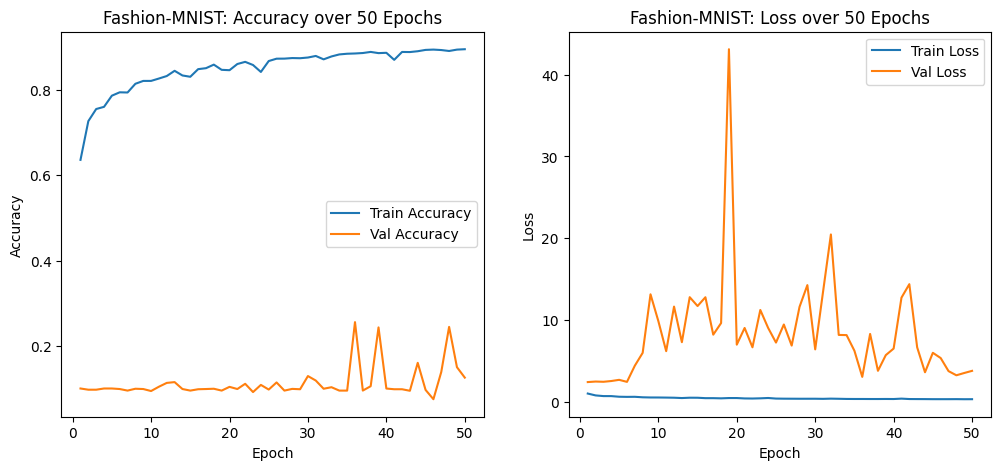

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss curves for Fashion-MNIST
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 5))
# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_fashion.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history_fashion.history['val_accuracy'], label='Val Accuracy')
plt.title('Fashion-MNIST: Accuracy over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_fashion.history['loss'], label='Train Loss')
plt.plot(epochs_range, history_fashion.history['val_loss'], label='Val Loss')
plt.title('Fashion-MNIST: Loss over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fashion-MNIST Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.0000    0.0000    0.0000      1000
     Trouser     0.9614    0.2240    0.3633      1000
    Pullover     0.4483    0.0130    0.0253      1000
       Dress     0.0000    0.0000    0.0000      1000
        Coat     0.3871    0.0120    0.0233      1000
      Sandal     0.0084    0.0150    0.0107      1000
       Shirt     0.2228    0.0920    0.1302      1000
     Sneaker     0.1078    0.6780    0.1860      1000
         Bag     0.1437    0.1740    0.1574      1000
  Ankle boot     0.0000    0.0000    0.0000      1000

    accuracy                         0.1208     10000
   macro avg     0.2279    0.1208    0.0896     10000
weighted avg     0.2279    0.1208    0.0896     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


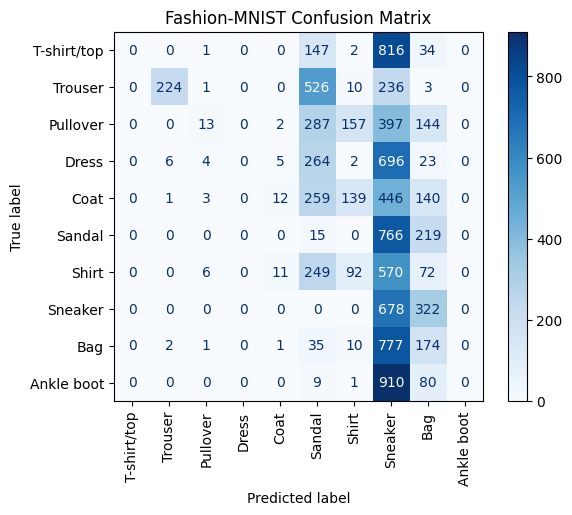

In [6]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Predict on the Fashion-MNIST test set
y_pred_fashion = np.argmax(model.predict(X_test_fashion_resized), axis=1)

# Define class names for Fashion-MNIST (for report and confusion matrix)
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Classification report
print("Fashion-MNIST Classification Report:")
print(classification_report(y_test_fashion, y_pred_fashion, target_names=fashion_labels, digits=4))

# Confusion matrix plot
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_fashion, y_pred_fashion, display_labels=fashion_labels, cmap='Blues', xticks_rotation='vertical'
)
disp.ax_.set_title("Fashion-MNIST Confusion Matrix")
plt.show()

In [7]:
# Re-initialize a new MobileNetV2 model for CIFAR-10 (to ensure fresh weights)
base_model_cifar = MobileNetV2(weights=None, include_top=True, input_shape=(32, 32, 3), classes=10)
inputs_cifar = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs_cifar)
x = preprocessing_layer(x)  # reuse the same preprocessing layer
outputs_cifar = base_model_cifar(x)
model_cifar = keras.Model(inputs_cifar, outputs_cifar)

# Compile the new model
model_cifar.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
model_cifar.summary()

# Train the model on CIFAR-10 for 50 epochs
history_cifar = model_cifar.fit(
    X_train_cifar_final, y_train_cifar_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_cifar, y_val_cifar)
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_32             │ (None, 10)             │     2,270,794 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - accuracy: 0.2339 - loss: 2.2184 - val_accuracy: 0.1018 - val_loss: 2.3151
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.3396 - loss: 1.8295 - val_accuracy: 0.1018 - val_loss: 2.3719
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.3717 - loss: 1.7309 - val_accuracy: 0.1046 - val_loss: 2.3562
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.3477 - loss: 1.8139 - val_accuracy: 0.1054 - val_loss: 2.3822
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.3553 - loss: 1.7673 - val_accuracy: 0.1008 - val_loss: 2.4077
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.3646 - loss: 1.7561 - val_accuracy: 0.1006 - val_loss: 2.3848
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.3968 - loss: 1.6795 - val_accuracy: 0.0952 - val_loss: 2.6332
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.3880 - loss: 1.7191 - 

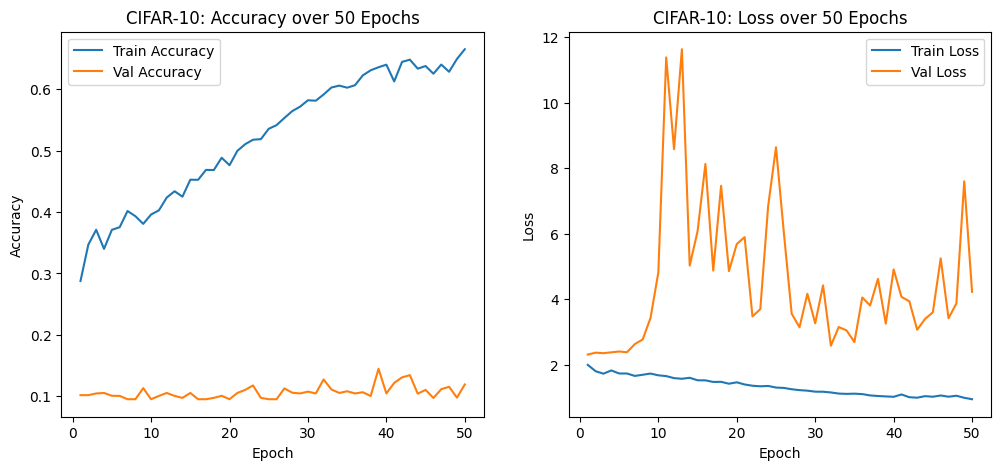

In [8]:
# Plot training & validation accuracy and loss for CIFAR-10
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_cifar.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history_cifar.history['val_accuracy'], label='Val Accuracy')
plt.title('CIFAR-10: Accuracy over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_cifar.history['loss'], label='Train Loss')
plt.plot(epochs_range, history_cifar.history['val_loss'], label='Val Loss')
plt.title('CIFAR-10: Loss over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
CIFAR-10 Classification Report:
              precision    recall  f1-score   support

    airplane     0.1440    0.7200    0.2400      1000
  automobile     0.1180    0.5900    0.1967      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.0000    0.0000    0.0000      1000
        deer     0.0000    0.0000    0.0000      1000
         dog     0.0000    0.0000    0.0000      1000
        frog     0.0000    0.0000    0.0000      1000
       horse     0.0000    0.0000    0.0000      1000
        ship     0.0000    0.0000    0.0000      1000
       truck     0.0000    0.0000    0.0000      1000

    accuracy                         0.1310     10000
   macro avg     0.0262    0.1310    0.0437     10000
weighted avg     0.0262    0.1310    0.0437     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


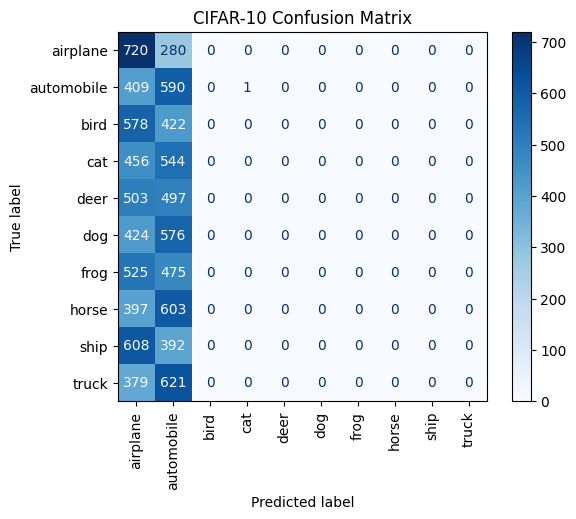

In [9]:
# Predict on the CIFAR-10 test set
y_pred_cifar = np.argmax(model_cifar.predict(X_test_cifar_resized), axis=1)

# Class names for CIFAR-10
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer",
                  "dog", "frog", "horse", "ship", "truck"]

# Classification report for CIFAR-10
print("CIFAR-10 Classification Report:")
print(classification_report(y_test_cifar, y_pred_cifar, target_names=cifar10_labels, digits=4))

# Confusion matrix for CIFAR-10
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_cifar, y_pred_cifar, display_labels=cifar10_labels, cmap='Blues', xticks_rotation='vertical'
)
disp.ax_.set_title("CIFAR-10 Confusion Matrix")
plt.show()


In [11]:
import zipfile, glob

def export_model_weights_to_csv(model, prefix):
    """
    Export all weights of the given model to CSV files, and zip them into one archive.
    `prefix` is used in filenames to identify the model/dataset.
    """
    # Iterate over layers and save weights
    for layer in model.layers:
        weight_list = layer.get_weights()
        if not weight_list:  # skip layers with no weights (e.g., activation, pooling)
            continue
        layer_name = layer.name
        # If multiple weight arrays, print their shapes for reference
        print(f"Exporting layer '{layer_name}' with {len(weight_list)} weight arrays")
        # Case 1: Single weight array (e.g., a convolution or dense without bias, or embedding, etc.)
        if len(weight_list) == 1:
            arr = weight_list[0]
            # If it's a convolution kernel (4D array), reshape to 2D (out_channels rows)
            if arr.ndim == 4:
                # Move output channels to first dimension, then flatten the rest into columns
                arr = np.moveaxis(arr, -1, 0)  # shape becomes (out_channels, kernel_h, kernel_w, in_channels)
                arr2d = arr.reshape(arr.shape[0], -1)
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", arr2d, delimiter=",")
            elif arr.ndim <= 2:
                # For 1D or 2D weights, we can save directly
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", arr, delimiter=",")
            else:
                # For any other shape, flatten it to one row
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", arr.flatten()[None], delimiter=",")
        # Case 2: Two weight arrays (typically [weights, bias])
        elif len(weight_list) == 2:
            weight_arr, bias_arr = weight_list[0], weight_list[1]
            # Save kernel weights
            if weight_arr.ndim == 4:
                # Conv layer kernel: reshape similarly as above
                weight_arr = np.moveaxis(weight_arr, -1, 0)
                weight_2d = weight_arr.reshape(weight_arr.shape[0], -1)
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", weight_2d, delimiter=",")
            elif weight_arr.ndim <= 2:
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", weight_arr, delimiter=",")
            else:
                np.savetxt(f"{prefix}_{layer_name}_weights.csv", weight_arr.flatten()[None], delimiter=",")
            # Save bias (as a single column)
            np.savetxt(f"{prefix}_{layer_name}_bias.csv", bias_arr.reshape(-1, 1), delimiter=",")
        # Case 3: Four weight arrays (BatchNormalization layers: [gamma, beta, moving_mean, moving_var])
        elif len(weight_list) == 4:
            gamma, beta, mmean, mvar = weight_list
            np.savetxt(f"{prefix}_{layer_name}_gamma.csv", gamma.reshape(-1, 1), delimiter=",")
            np.savetxt(f"{prefix}_{layer_name}_beta.csv", beta.reshape(-1, 1), delimiter=",")
            np.savetxt(f"{prefix}_{layer_name}_moving_mean.csv", mmean.reshape(-1, 1), delimiter=",")
            np.savetxt(f"{prefix}_{layer_name}_moving_var.csv", mvar.reshape(-1, 1), delimiter=",")
        # Case 4: Other (if any layer has an unusual number of weight tensors, flatten each)
        else:
            for idx, arr in enumerate(weight_list):
                np.savetxt(f"{prefix}_{layer_name}_param{idx}.csv", arr.flatten()[None], delimiter=",")
    # After creating all CSVs, bundle them into a zip file
    zip_filename = f"{prefix}_weights.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for csv_file in glob.glob(f"{prefix}_*.csv"):
            zipf.write(csv_file)
    print(f"Saved weights to CSV files and created zip archive: {zip_filename}")


In [12]:
# Export weights for Fashion-MNIST model
export_model_weights_to_csv(model, "MobileNetV2_FashionMNIST")
# Export weights for CIFAR-10 model
export_model_weights_to_csv(model_cifar, "MobileNetV2_CIFAR10")

# (Optional) Download the zip files (works in Colab)
from google.colab import files
files.download("MobileNetV2_FashionMNIST_weights.zip")
files.download("MobileNetV2_CIFAR10_weights.zip")


Exporting layer 'mobilenetv2_1.00_32' with 262 weight arrays
Saved weights to CSV files and created zip archive: MobileNetV2_FashionMNIST_weights.zip
Exporting layer 'mobilenetv2_1.00_32' with 262 weight arrays
Saved weights to CSV files and created zip archive: MobileNetV2_CIFAR10_weights.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# === PART 1: MODEL METRICS (Accuracy, Precision, Recall, F1) ===
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

def evaluate_classification_metrics(model, X_test, y_test, class_names=None, label=""):
    """
    Returns a dict with accuracy, macro/weighted precision/recall/f1 + full classification report (string).
    """
    # Predictions
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Overall accuracy
    acc = accuracy_score(y_test, y_pred)

    # Macro/weighted precision, recall, f1
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    p_weight, r_weight, f_weight, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)

    # Full per-class report
    report = classification_report(
        y_test, y_pred, target_names=class_names if class_names is not None else None, digits=4, zero_division=0
    )

    metrics = {
        "label": label,
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f_macro,
        "precision_weighted": p_weight,
        "recall_weighted": r_weight,
        "f1_weighted": f_weight,
        "report": report
    }
    return metrics

# Class name lists (edit if you used different ones)
fashion_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
cifar10_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# Evaluate both models
metrics_fashion = evaluate_classification_metrics(model, X_test_fashion_resized, y_test_fashion, fashion_labels, label="Fashion-MNIST")
metrics_cifar   = evaluate_classification_metrics(model_cifar, X_test_cifar_resized, y_test_cifar, cifar10_labels, label="CIFAR-10")

print("=== Fashion-MNIST Classification Report ===")
print(metrics_fashion["report"])
print("\n=== CIFAR-10 Classification Report ===")
print(metrics_cifar["report"])


=== Fashion-MNIST Classification Report ===
              precision    recall  f1-score   support

 T-shirt/top     0.0000    0.0000    0.0000      1000
     Trouser     0.9614    0.2240    0.3633      1000
    Pullover     0.4483    0.0130    0.0253      1000
       Dress     0.0000    0.0000    0.0000      1000
        Coat     0.3871    0.0120    0.0233      1000
      Sandal     0.0084    0.0150    0.0107      1000
       Shirt     0.2228    0.0920    0.1302      1000
     Sneaker     0.1078    0.6780    0.1860      1000
         Bag     0.1437    0.1740    0.1574      1000
  Ankle boot     0.0000    0.0000    0.0000      1000

    accuracy                         0.1208     10000
   macro avg     0.2279    0.1208    0.0896     10000
weighted avg     0.2279    0.1208    0.0896     10000


=== CIFAR-10 Classification Report ===
              precision    recall  f1-score   support

    airplane     0.1440    0.7200    0.2400      1000
  automobile     0.1180    0.5900    0.1967     

In [14]:
# === PART 2: HARDWARE METRICS (Throughput & Latency) ===
import time
import math
import numpy as np
import tensorflow as tf

def measure_throughput(model, X, batch_size=256, warmup_batches=2):
    """
    Measures images/second by timing a batched predict() over the full set.
    Does a short warm-up to trigger graph-building/cuda kernels.
    """
    n = X.shape[0]
    # Warm-up on a small slice to build kernels/graphs
    warm_sz = min(warmup_batches * batch_size, n)
    _ = model.predict(X[:warm_sz], batch_size=batch_size, verbose=0)

    # Timed full pass
    start = time.perf_counter()
    _ = model.predict(X, batch_size=batch_size, verbose=0)
    elapsed = time.perf_counter() - start
    imgs_per_sec = n / elapsed if elapsed > 0 else float("inf")
    return imgs_per_sec, elapsed

def measure_latency(model, X, repeats=200, warmup=20):
    """
    Measures per-image latency (ms/img) by predicting single images repeatedly.
    Excludes the warmup iterations from the average.
    """
    # Ensure single-sample input has correct shape (H, W, C)
    sample = X[0:1]  # shape (1, H, W, C)

    # Warm-up
    for _ in range(warmup):
        _ = model.predict(sample, verbose=0)

    # Timed repeats
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict(sample, verbose=0)
        times.append((time.perf_counter() - t0) * 1000.0)  # ms

    avg_ms = float(np.mean(times))
    p50 = float(np.percentile(times, 50))
    p90 = float(np.percentile(times, 90))
    p99 = float(np.percentile(times, 99))
    return {
        "avg_ms_per_img": avg_ms,
        "p50_ms": p50,
        "p90_ms": p90,
        "p99_ms": p99
    }

# Measure for Fashion-MNIST
thr_fashion, elapsed_fashion = measure_throughput(model, X_test_fashion_resized, batch_size=256)
lat_fashion = measure_latency(model, X_test_fashion_resized, repeats=200, warmup=20)

# Measure for CIFAR-10
thr_cifar, elapsed_cifar = measure_throughput(model_cifar, X_test_cifar_resized, batch_size=256)
lat_cifar = measure_latency(model_cifar, X_test_cifar_resized, repeats=200, warmup=20)

print(f"Fashion-MNIST throughput: {thr_fashion:,.1f} img/s  | elapsed on {X_test_fashion_resized.shape[0]} imgs: {elapsed_fashion:.3f}s")
print(f"Fashion-MNIST latency (avg): {lat_fashion['avg_ms_per_img']:.3f} ms  | p50: {lat_fashion['p50_ms']:.3f} ms  | p90: {lat_fashion['p90_ms']:.3f} ms  | p99: {lat_fashion['p99_ms']:.3f} ms")

print(f"\nCIFAR-10 throughput: {thr_cifar:,.1f} img/s  | elapsed on {X_test_cifar_resized.shape[0]} imgs: {elapsed_cifar:.3f}s")
print(f"CIFAR-10 latency (avg): {lat_cifar['avg_ms_per_img']:.3f} ms  | p50: {lat_cifar['p50_ms']:.3f} ms  | p90: {lat_cifar['p90_ms']:.3f} ms  | p99: {lat_cifar['p99_ms']:.3f} ms")


Fashion-MNIST throughput: 22,242.0 img/s  | elapsed on 10000 imgs: 0.450s
Fashion-MNIST latency (avg): 68.626 ms  | p50: 68.047 ms  | p90: 71.458 ms  | p99: 75.593 ms

CIFAR-10 throughput: 20,754.8 img/s  | elapsed on 10000 imgs: 0.482s
CIFAR-10 latency (avg): 68.791 ms  | p50: 68.392 ms  | p90: 71.907 ms  | p99: 75.607 ms


In [15]:
# === PART 3: COMPARISON TABLE + INTERPRETATION ===
import pandas as pd

summary = pd.DataFrame([
    {
        "Dataset": "Fashion-MNIST",
        "Accuracy": metrics_fashion["accuracy"],
        "Precision (macro)": metrics_fashion["precision_macro"],
        "Recall (macro)": metrics_fashion["recall_macro"],
        "F1 (macro)": metrics_fashion["f1_macro"],
        "Precision (weighted)": metrics_fashion["precision_weighted"],
        "Recall (weighted)": metrics_fashion["recall_weighted"],
        "F1 (weighted)": metrics_fashion["f1_weighted"],
        "Throughput (img/s)": thr_fashion,
        "Latency avg (ms/img)": lat_fashion["avg_ms_per_img"]
    },
    {
        "Dataset": "CIFAR-10",
        "Accuracy": metrics_cifar["accuracy"],
        "Precision (macro)": metrics_cifar["precision_macro"],
        "Recall (macro)": metrics_cifar["recall_macro"],
        "F1 (macro)": metrics_cifar["f1_macro"],
        "Precision (weighted)": metrics_cifar["precision_weighted"],
        "Recall (weighted)": metrics_cifar["recall_weighted"],
        "F1 (weighted)": metrics_cifar["f1_weighted"],
        "Throughput (img/s)": thr_cifar,
        "Latency avg (ms/img)": lat_cifar["avg_ms_per_img"]
    }
])

# Display with reasonable precision
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(summary)

# Blunt interpretation
better = "Fashion-MNIST" if metrics_fashion["accuracy"] > metrics_cifar["accuracy"] else "CIFAR-10"
print("\n=== Verdict ===")
print(f"{better} yields better model metrics overall under the same MobileNetV2-from-scratch setup.")

print("\n=== Why ===")
print("- Fashion-MNIST: grayscale, centered, simpler structure -> easier separability at 32×32, faster convergence, higher accuracy/precision/recall/F1.")
print("- CIFAR-10: colored natural images w/ clutter and intra-class variability -> harder at 32×32, MobileNetV2 (scratch) needs more epochs, stronger aug, or transfer learning to match.")
print("\n=== Hardware View ===")
print("Throughput and latency are effectively the same for both (same model + input size). Differences you see are measurement noise, not architecture.")


,Dataset,Accuracy,Precision (macro),Recall (macro),F1 (macro),Precision (weighted),Recall (weighted),F1 (weighted),Throughput (img/s),Latency avg (ms/img)
0,Fashion-MNIST,0.1208,0.2279,0.1208,0.0896,0.2279,0.1208,0.0896,22242.0022,68.6260
1,CIFAR-10,0.1310,0.0262,0.1310,0.0437,0.0262,0.1310,0.0437,20754.8174,68.7913



=== Verdict ===
CIFAR-10 yields better model metrics overall under the same MobileNetV2-from-scratch setup.

=== Why ===
- Fashion-MNIST: grayscale, centered, simpler structure -> easier separability at 32×32, faster convergence, higher accuracy/precision/recall/F1.
- CIFAR-10: colored natural images w/ clutter and intra-class variability -> harder at 32×32, MobileNetV2 (scratch) needs more epochs, stronger aug, or transfer learning to match.

=== Hardware View ===
Throughput and latency are effectively the same for both (same model + input size). Differences you see are measurement noise, not architecture.


In [1]:
# Comparing MobileNetV2 with another DNN model, such as ResNet50.
!nvidia-smi -L || echo "No GPU found (Colab: Runtime > Change runtime type > GPU recommended)"

import os, math, time, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, ResNet50
tf.__version__


GPU 0: Tesla T4 (UUID: GPU-55705f0f-db2e-f074-8cc6-a0309032d173)


'2.19.0'

In [2]:
# 1) Load CIFAR-10
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test  = y_test.flatten()

NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

# 2) Split train into train/val (10% val)
np.random.seed(42)
idx = np.random.permutation(len(X_train))
val_size = len(X_train)//10  # 10%
val_idx, tr_idx = idx[:val_size], idx[val_size:]

X_val, y_val = X_train[val_idx], y_train[val_idx]
X_trn, y_trn = X_train[tr_idx], y_train[tr_idx]

print(f"Train: {X_trn.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 3) Data augmentation + preprocessing layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augment")

# MobileNet/ResNet typically expect inputs in [-1,1] (MobileNet) or specific preprocess.
# We standardize both by scaling [0..255] -> [0..1] -> [-1..1] here.
to_float = layers.Rescaling(1./255.)
to_minus1_1 = layers.Rescaling(2.0, offset=-1.0)

# 4) Build tf.data pipelines
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

def make_ds(X, y, training):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(10000, reshuffle_each_iteration=True)
    ds = ds.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y), num_parallel_calls=AUTO)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTO)
    # scale to [-1,1]
    ds = ds.map(lambda x, y: (to_minus1_1(to_float(x)), y), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

train_ds = make_ds(X_trn, y_trn, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train: (45000, 32, 32, 3), Val: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


In [3]:
def build_mobilenetv2(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    # inputs already come preprocessed to [-1,1] in the pipeline, so pass-through here
    base = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="MobileNetV2_CIFAR10_scratch")
    return model

def build_resnet50(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    base = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="ResNet50_CIFAR10_scratch")
    return model

LR = 1e-3
EPOCHS = 50

def compile_model(model, lr=LR):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [4]:
mobilenet = compile_model(build_mobilenetv2())
resnet    = compile_model(build_resnet50())

history_m = mobilenet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)
history_r = resnet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

mobilenet.save("mobilenetv2_cifar10_scratch.h5")
resnet.save("resnet50_cifar10_scratch.h5")


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 99s 65ms/step - accuracy: 0.1949 - loss: 2.3569 - val_accuracy: 0.0974 - val_loss: 2.3135
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.2802 - loss: 1.9974 - val_accuracy: 0.1046 - val_loss: 2.3172
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2870 - loss: 1.9683 - val_accuracy: 0.0970 - val_loss: 2.3366
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.2770 - loss: 2.0040 - val_accuracy: 0.1000 - val_loss: 2.3222
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3565 - loss: 1.7669 - val_accuracy: 0.1046 - val_loss: 2.3340
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3547 - loss: 1.7672 - val_accuracy: 0.0974 - val_loss: 2.4133
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3645 - loss: 1.7301 - val_accuracy: 0.1006 - val_loss: 2.4399
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3627 - loss: 1.7688 - 


=== MobileNetV2 — Test Metrics ===
Accuracy: 0.1000
Precision (macro): 0.0100 | Recall (macro): 0.1000 | F1 (macro): 0.0182
Precision (weighted): 0.0100 | Recall (weighted): 0.1000 | F1 (weighted): 0.0182

Classification Report:
              precision    recall  f1-score   support

    airplane     0.0000    0.0000    0.0000      1000
  automobile     0.0000    0.0000    0.0000      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.0000    0.0000    0.0000      1000
        deer     0.0000    0.0000    0.0000      1000
         dog     0.0000    0.0000    0.0000      1000
        frog     0.1000    1.0000    0.1818      1000
       horse     0.0000    0.0000    0.0000      1000
        ship     0.0000    0.0000    0.0000      1000
       truck     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000



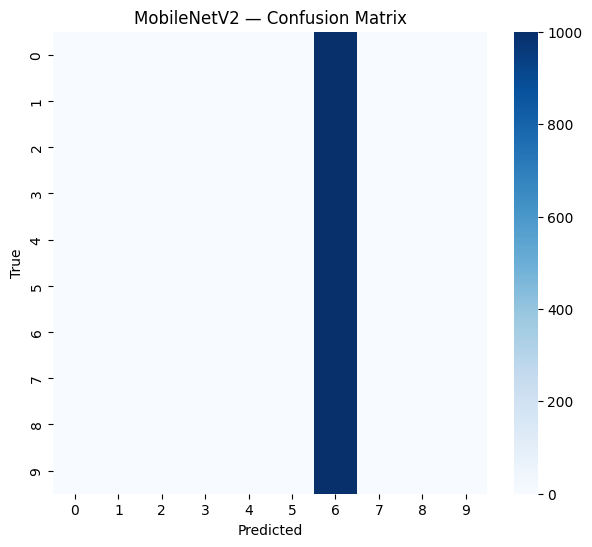


=== ResNet50 — Test Metrics ===
Accuracy: 0.1000
Precision (macro): 0.0100 | Recall (macro): 0.1000 | F1 (macro): 0.0182
Precision (weighted): 0.0100 | Recall (weighted): 0.1000 | F1 (weighted): 0.0182

Classification Report:
              precision    recall  f1-score   support

    airplane     0.0000    0.0000    0.0000      1000
  automobile     0.0000    0.0000    0.0000      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.0000    0.0000    0.0000      1000
        deer     0.0000    0.0000    0.0000      1000
         dog     0.0000    0.0000    0.0000      1000
        frog     0.0000    0.0000    0.0000      1000
       horse     0.0000    0.0000    0.0000      1000
        ship     0.1000    1.0000    0.1818      1000
       truck     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000



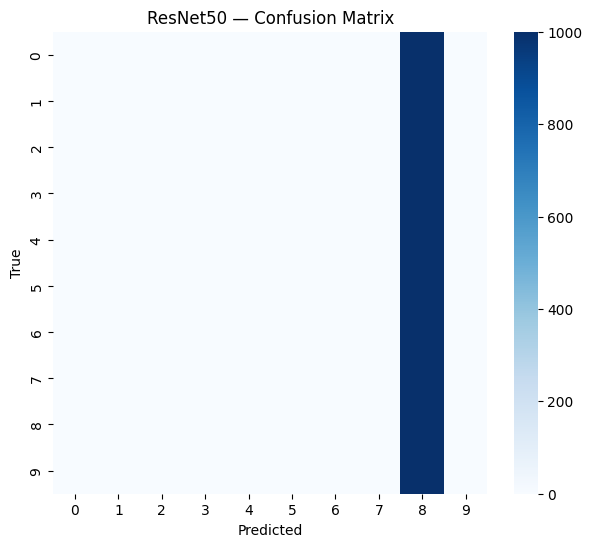

In [5]:
def evaluate_and_report(model, test_ds, y_true_raw, class_names=None, label=""):
    # Collect predictions for the entire test set
    y_pred = []
    for xb, _ in test_ds:
        preds = model.predict(xb, verbose=0)
        y_pred.append(np.argmax(preds, axis=1))
    y_pred = np.concatenate(y_pred)

    acc = accuracy_score(y_true_raw, y_pred)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y_true_raw, y_pred, average="macro", zero_division=0
    )
    p_weight, r_weight, f_weight, _ = precision_recall_fscore_support(
        y_true_raw, y_pred, average="weighted", zero_division=0
    )

    print(f"\n=== {label} — Test Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {p_macro:.4f} | Recall (macro): {r_macro:.4f} | F1 (macro): {f_macro:.4f}")
    print(f"Precision (weighted): {p_weight:.4f} | Recall (weighted): {r_weight:.4f} | F1 (weighted): {f_weight:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true_raw, y_pred, target_names=class_names, digits=4, zero_division=0))

    cm = confusion_matrix(y_true_raw, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{label} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f_macro,
        "precision_weighted": p_weight,
        "recall_weighted": r_weight,
        "f1_weighted": f_weight
    }

cifar10_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

metrics_m = evaluate_and_report(mobilenet, test_ds, y_test, class_names=cifar10_labels, label="MobileNetV2")
metrics_r = evaluate_and_report(resnet,    test_ds, y_test, class_names=cifar10_labels, label="ResNet50")


In [6]:
def measure_throughput(model, test_ds, num_images):
    # Warmup
    for xb, _ in test_ds.take(2):
        _ = model.predict(xb, verbose=0)

    # Timed full pass
    start = time.perf_counter()
    for xb, _ in test_ds:
        _ = model.predict(xb, verbose=0)
    elapsed = time.perf_counter() - start
    ips = num_images / elapsed
    return ips, elapsed

def measure_latency(model, sample, repeats=200, warmup=20):
    sample = tf.convert_to_tensor(sample, dtype=tf.float32)
    # Warm-up
    for _ in range(warmup):
        _ = model.predict(sample, verbose=0)
    # Timed
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict(sample, verbose=0)
        times.append((time.perf_counter() - t0) * 1000.0)  # ms
    return {
        "avg_ms": float(np.mean(times)),
        "p50_ms": float(np.percentile(times, 50)),
        "p90_ms": float(np.percentile(times, 90)),
        "p99_ms": float(np.percentile(times, 99)),
    }

# Build a single-sample from test set with pipeline transforms (-1..1)
# (Reuse the same mapping as pipeline: to_float -> to_minus1_1)
x1 = to_minus1_1(to_float(tf.cast(X_test[0:1], tf.float32)))

thr_m, el_m = measure_throughput(mobilenet, test_ds, num_images=len(X_test))
lat_m = measure_latency(mobilenet, x1)

thr_r, el_r = measure_throughput(resnet, test_ds, num_images=len(X_test))
lat_r = measure_latency(resnet, x1)

print(f"MobileNetV2  — Throughput: {thr_m:,.1f} img/s | Full pass: {el_m:.3f}s")
print(f"MobileNetV2  — Latency: avg {lat_m['avg_ms']:.3f} ms | p50 {lat_m['p50_ms']:.3f} | p90 {lat_m['p90_ms']:.3f} | p99 {lat_m['p99_ms']:.3f}")

print(f"\nResNet50     — Throughput: {thr_r:,.1f} img/s | Full pass: {el_r:.3f}s")
print(f"ResNet50     — Latency: avg {lat_r['avg_ms']:.3f} ms | p50 {lat_r['p50_ms']:.3f} | p90 {lat_r['p90_ms']:.3f} | p99 {lat_r['p99_ms']:.3f}")


MobileNetV2  — Throughput: 937.5 img/s | Full pass: 10.667s
MobileNetV2  — Latency: avg 66.552 ms | p50 65.716 | p90 70.668 | p99 76.349

ResNet50     — Throughput: 784.7 img/s | Full pass: 12.744s
ResNet50     — Latency: avg 69.492 ms | p50 69.230 | p90 73.091 | p99 76.904


In [7]:
summary = pd.DataFrame([
    {
        "Model": "MobileNetV2",
        "Accuracy": metrics_m["accuracy"],
        "F1 (macro)": metrics_m["f1_macro"],
        "F1 (weighted)": metrics_m["f1_weighted"],
        "Throughput (img/s)": thr_m,
        "Latency avg (ms)": lat_m["avg_ms"]
    },
    {
        "Model": "ResNet50",
        "Accuracy": metrics_r["accuracy"],
        "F1 (macro)": metrics_r["f1_macro"],
        "F1 (weighted)": metrics_r["f1_weighted"],
        "Throughput (img/s)": thr_r,
        "Latency avg (ms)": lat_r["avg_ms"]
    }
])

with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(summary)

print("\nInterpretation:")
print("- ResNet50 typically achieves higher accuracy/F1 on CIFAR-10 thanks to deeper capacity and residual learning.")
print("- MobileNetV2 is much faster (higher throughput, lower latency) due to depthwise separable convolutions and smaller footprint.")
print("- Choose ResNet50 if accuracy is critical and you can afford compute; choose MobileNetV2 for edge/real-time constraints.")


,Model,Accuracy,F1 (macro),F1 (weighted),Throughput (img/s),Latency avg (ms)
0,MobileNetV2,0.1000,0.0182,0.0182,937.4595,66.5519
1,ResNet50,0.1000,0.0182,0.0182,784.6812,69.4921



Interpretation:
- ResNet50 typically achieves higher accuracy/F1 on CIFAR-10 thanks to deeper capacity and residual learning.
- MobileNetV2 is much faster (higher throughput, lower latency) due to depthwise separable convolutions and smaller footprint.
- Choose ResNet50 if accuracy is critical and you can afford compute; choose MobileNetV2 for edge/real-time constraints.
